In [1]:
import numpy as np
import matplotlib as plt
from keras.models import Sequential, load_model
from PIL import Image
import timeit,time
import math
import pandas as pd

from skimage import measure
from scipy import ndimage as ndi
from skimage import feature

Using TensorFlow backend.


In [2]:
# load the model
path = '/home/grads/n/narendra5/Desktop/Programs/LER_machine_learning/'
#path = r"C:\\Users\\narendra\\Documents\\LER\\LER_machine_learning\\"

#model = load_model(path + r'models\\' + 'full_run1_epoch_4.h5')
model = load_model(path + 'models/' + 'full_run1_epoch_4.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1024, 64, 64)      640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024, 64, 64)      256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024, 64, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1024, 64, 64)      36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024, 64, 64)      256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024, 64, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1024, 64, 64)      36928     
__________

In [20]:
"""
Entire Test set 

sigmas = [0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
Xis = [10, 30, 40]
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
widths = [20, 30]
noises = [2, 3, 4, 5, 10, 20, 30, 50, 100, 200]
"""

sigmas = [0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
Xis = [10, 30, 40]
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
widths = [20, 30]
noises = [2, 3, 4, 5, 10, 20, 30, 50, 100, 200]

testsize = len(sigmas)*len(Xis)*len(alphas)*len(widths)*len(noises)*2
print('Testsize: ', testsize)


df = pd.DataFrame(columns = ['noise', 'sigma', 'alpha', 'Xi', 'width', 'space', 'MSE_noise','MSE_pred', \
                             'PSNR_noise','PSNR_pred', 'Pred_time', 'O_leftline_sigma', 'i_leftline_sigma', \
                             'O_rightline_sigma', 'i_rightline_sigma', 'ledge_orig_sigma', 'ledge_pred_sigma', \
                             'redge_orig_sigma', 'redge_pred_sigma', 'lorig_rmse', 'lpred_rmse', 'rorig_rmse', \
                             'rpred_rmse', 'ldiff_rmse','rdiff_rmse'])

count = 0
for sigma in sigmas:
    for alpha in alphas:
        for Xi in Xis:
            for width in widths:
                for s in range(2):
                    for noise in noises:
                        space = math.floor(width*2**s)
                        shift = math.floor(-25 + (width + space/2 + Xi + alpha*10 + sigma*10)%16) 
                        
                        original_file = path + 'original_images/oim_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + '.tiff'
                        noisy_file = path + 'noisy_images/nim_' + "{0:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + '_' + str(noise) + '.tiff'
                        linescan_file = path + 'linescans/linescan_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '.txt'
                        linescan = []
                        with open(linescan_file,'r') as f:
                            for line in f:
                                a, b = line.split(',')
                                linescan.append(float(b))
                        
                        linescan = linescan[:2048]
                        
                        leftline = np.array(linescan[:1024]) 
                        rightline = linescan[1024:]
                        rightline.reverse()
                        rightline = np.array(rightline)

                        leftline = leftline + shift           # add shift to linescan
                        rightline = rightline + shift         # add shift to linescan
                        
                        
                        im = np.array(Image.open(original_file))
                        imnoisy = np.array(Image.open(noisy_file))
                        
                        im = im/256
                        imnoisy = imnoisy/256
                        imnoisy = imnoisy.reshape(1,1024,64,1)
                        im = im.reshape(1,1024,64,1)
                        
                        #test_score = model.evaluate(imnoisy, im)
                        start = time.time()
                        impredict = model.predict(imnoisy)
                        prediction_time = time.time() - start
                        
                        
                        impredict = impredict.reshape(1024,64)
                        imnoisy = imnoisy.reshape(1024,64)
                        im = im.reshape(1024,64)
                        impredict = impredict.astype(float)
                        imnoisy = imnoisy.astype(float)
                        im = im.astype(float)
                        
                        mse_predict = (256**2)*((im - impredict) ** 2).mean()
                        mse_noisy = (256**2)*((im - imnoisy) ** 2).mean()
                        
                        psnr_noisy = measure.compare_psnr(im,imnoisy)
                        psnr_predict = measure.compare_psnr(im,impredict)
                        
                        canny_sigma = 1
                        edges_im = feature.canny(im, sigma = canny_sigma)
                        edges_imnoisy = feature.canny(imnoisy, sigma = canny_sigma)
                        edges_impredict = feature.canny(impredict, sigma = canny_sigma)
                        
                        ledge_orig = np.argmax(edges_im, axis = 1)[256:768]
                        redge_orig = np.argmax(np.fliplr(edges_im), axis = 1)[256:768]
                        redge_orig = 62 - redge_orig
                        
                        ledge_pred = np.argmax(edges_impredict, axis = 1)[256:768]
                        redge_pred = np.argmax(np.fliplr(edges_impredict), axis = 1)[256:768]
                        redge_pred = 62 - redge_pred
                        
                        lorig_rmse = np.sqrt(((leftline[255:767].astype(int) - ledge_orig)**2).mean())
                        rorig_rmse = np.sqrt(((rightline[255:767].astype(int) - redge_orig)**2).mean())
                        
                        lpred_rmse = np.sqrt(((leftline[255:767].astype(int) - ledge_pred)**2).mean())
                        rpred_rmse = np.sqrt(((rightline[255:767].astype(int) - redge_pred)**2).mean())
                        
                        ldiff_rmse = np.sqrt(((ledge_orig - ledge_pred)**2).mean())
                        rdiff_rmse = np.sqrt(((redge_orig - redge_pred)**2).mean())
                        
                        df.loc[count] = [noise, sigma, alpha, Xi, width, space, mse_noisy, mse_predict, \
                                         psnr_noisy, psnr_predict, prediction_time, leftline[255:767].std()/2, \
                                         leftline[255:767].astype(int).std()/2, rightline[255:767].std()/2, \
                                         rightline[255:767].astype(int).std()/2, ledge_orig.std()/2, \
                                         ledge_pred.std()/2, redge_orig.std()/2, redge_pred.std()/2, lorig_rmse, \
                                         lpred_rmse, rorig_rmse, rpred_rmse, ldiff_rmse, rdiff_rmse]
                        
                        count += 1
                        
print("Test count: ", count)
#print(df)

Testsize:  8640
Test count:  8640


In [3]:
df.to_csv(path + 'Test_results.csv')

NameError: name 'df' is not defined

In [2]:
path = '/home/grads/n/narendra5/Desktop/Programs/LER_machine_learning/'
df = pd.DataFrame.from_csv(path + 'Test_results.csv')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


In [35]:
print(df.loc[(df['noise'] == 10) & (df['sigma'] == 0.8) & (df['alpha'] == 0.3) & (df['Xi'] == 10) & (df['width'] == 20) & (df['space'] == 20)])
#print(df.loc[(df['noise'] == 2) & (df['sigma'] == 1.2) & (df['alpha'] == 0.7) & (df['Xi'] == 40) & (df['width'] == 30) & (df['space'] == 30)])
#print(df.loc[(df['noise'] == 100) & (df['sigma'] == 1.6) & (df['alpha'] == 0.5) & (df['Xi'] == 30) & (df['width'] == 20) & (df['space'] == 40)])

      noise  sigma  alpha    Xi  width  space    MSE_noise   MSE_pred  \
2404   10.0    0.8    0.3  10.0   20.0   20.0  1563.428375  89.903817   
2444   10.0    0.8    0.3  30.0   20.0   20.0  1526.973190  68.958134   
2484   10.0    0.8    0.3  40.0   20.0   20.0  1535.277618  72.462501   

      PSNR_noise  PSNR_pred     ...      ledge_orig_sigma  ledge_pred_sigma  \
2404   16.224019  28.627018     ...              0.629740          0.602005   
2444   16.326485  29.778944     ...              0.731606          0.720822   
2484   16.302930  29.563666     ...              0.682510          0.681434   

      redge_orig_sigma  redge_pred_sigma  lorig_rmse  lpred_rmse  rorig_rmse  \
2404          0.638594          0.660225    0.712610    0.806468    0.771818   
2444          0.804511          0.801457    0.513490    0.591278    0.597848   
2484          0.766570          0.771442    0.528485    0.601106    0.589624   

      rpred_rmse  ldiff_rmse  rdiff_rmse  
2404    0.870524    0.4901

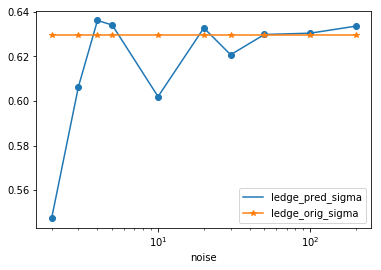

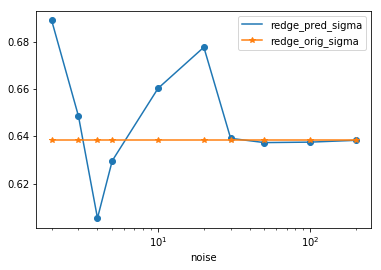

In [43]:
%matplotlib inline
df1 = df.loc[(df['sigma'] == 0.8) & (df['alpha'] == 0.3) & (df['Xi'] == 10) & (df['width'] == 20) & (df['space'] == 20)]
#df1 = df.loc[(df['sigma'] == 1.2) & (df['alpha'] == 0.7) & (df['Xi'] == 40) & (df['width'] == 30) & (df['space'] == 30)]
#df1 = df.loc[(df['sigma'] == 1.6) & (df['alpha'] == 0.5) & (df['Xi'] == 30) & (df['width'] == 20) & (df['space'] == 40)]

ax = df1.plot(x = 'noise', y = 'ledge_pred_sigma', style = '-o', logx = True)
df1.plot(x = 'noise', y = 'ledge_orig_sigma', style = '-*', ax = ax, logx = True)

ax = df1.plot(x = 'noise', y = 'redge_pred_sigma', style = '-o', logx = True)
df1.plot(x = 'noise', y = 'redge_orig_sigma', style = '-*', ax = ax, logx = True)